<a href="https://colab.research.google.com/github/TAUforPython/stohasticsignal/blob/main/example%20stochastic%20process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scipy -q

In [ ]:

!pip install seaborn
!pip install MFDFA
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 24.4 MB/s eta 0:00:00


In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import mne
from scipy import signal

# создаем данные для обработки

либо загрузить, либо сгенерировать сигнал. Запустить что-то одно.

In [ ]:
# пример загрузки данных из внешнего файла csv
# загрузить курс доллара


# пример загрузки данных из внешнего файла csv
# загрузить курс доллара
data_usdrub = pd.read_csv("UsdRubTime.csv", sep = ';')

df_usdrub = pd.DataFrame(data_usdrub, columns = ['Close', 'Position'])

print(df_usdrub.head)
y = df_usdrub['Close'].values

T = max(df_usdrub['Position'])
N = len(df_usdrub['Position'])
t = np.linspace(1, T, N)


#t = df_usdrub['day'].values
#t = np.sort(t)

<bound method NDFrame.head of        Close  Position
0      0.988         1
1      0.993         8
2      1.000        15
3      1.020        22
4      1.300        29
...      ...       ...
1537  73.348     10760
1538  74.230     10767
1539  76.135     10774
1540  75.712     10781
1541  76.072     10788

[1542 rows x 2 columns]>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# путь к файлу на гугл-диске
edf_path = '/content/drive/MyDrive/edf_process/EDF_example_FS_healthy.edf'

# загрузка файла (данные в структуре переданы в переменную)
data_from_raw_edf = mne.io.read_raw_edf(edf_path, preload=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracting EDF parameters from /content/drive/MyDrive/edf_process/EDF_example_FS_healthy.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 28799  =      0.000 ...   224.992 secs...


In [ ]:
# ECG
#edf_path = '/content/drive/MyDrive/edf_process/ECG_example.edf'
edf_path = '/content/drive/MyDrive/edf_process/ECGrhmn_example.edf'

Using matplotlib as 2D backend.
['EEG Fp1-G2', 'EEG Fpz-G2', 'EEG Fp2-G2', 'EEG F7-G2', 'EEG F3-G2', 'EEG Fz-G2', 'EEG F4-G2', 'EEG F8-G2', 'EEG T3-G2', 'EEG C3-G2', 'EEG Cz-G2', 'EEG C4-G2', 'EEG T4-G2', 'EEG T5-G2', 'EEG P3-G2', 'EEG Pz-G2', 'EEG P4-G2', 'EEG T6-G2', 'EEG O1-G2', 'EEG O2-G2', 'EEG F9-G2', 'EEG T9-G2', 'EEG ECG-G2', 'EEG P9-G2', 'EEG F10-G2', 'EEG T10-G2', 'EEG P10-G2', 'Value MKR+-MKR-']


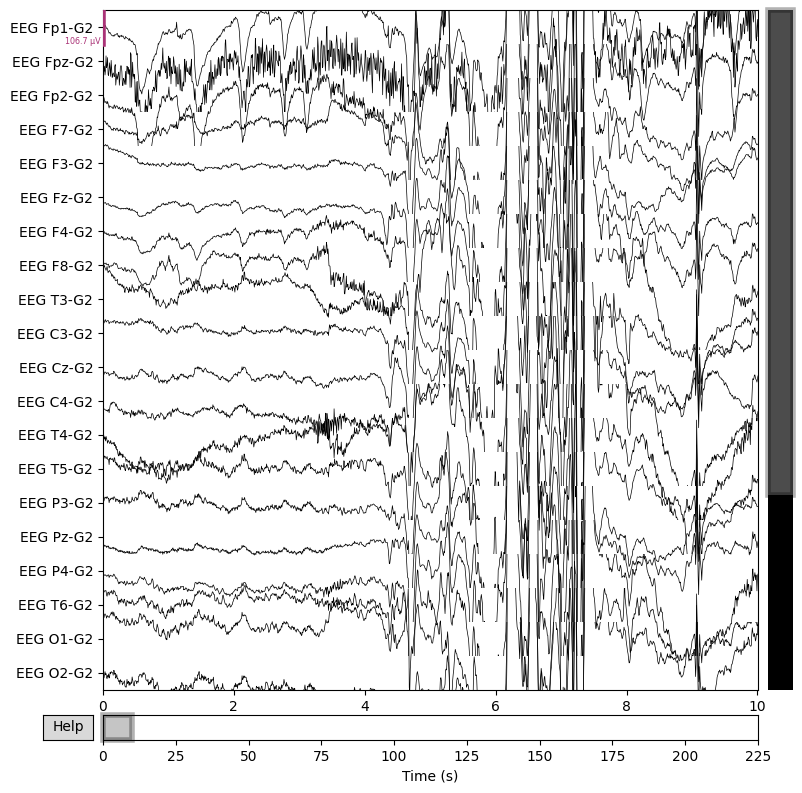

In [ ]:
# EDF - файл содержит многоканальную запись ЭЭГ
# ECG - файл содержит запись электрокардиограммы
data_from_raw_edf.plot(scalings = 'auto', show = False)
# список каналов из файла EDF
print(data_from_raw_edf.ch_names)

In [ ]:
eeg_data, eeg_times = data_from_raw_edf.get_data(return_times=True)
print('число отчетов во временном ряду:',len(eeg_times))
# устанавливаем диапазон для обработки данных
t_index_begin = 1500
t_index_end = 20000
t = eeg_times[t_index_begin:t_index_end]
# значение времени = конец сигнала
T = t[-1]
# число элементов во временном ряду
N = len(t)
# выгружаем в выходную переменную, например, первый (в Питоне он нулевой индекс имеет) канал
y = eeg_data[5, t_index_begin:t_index_end]

число отчетов во временном ряду: 28800


In [ ]:
# функция генерации сигнала стохастического
# additive white gaussian noise
def awgn(mu, noise_sigma, data_size, white_noise_power):
    t = np.arange(0, data_size, 1.)
    #random.seed(random_state)
    noise = np.empty((data_size, 1))
    y = np.empty((data_size))

    for i in range(data_size):
        random.seed(int(t[i]))
        noise[i] = random.gauss(mu, noise_sigma)
        #noise[i] = random.uniform(0, 1)
        y[i] = white_noise_power * noise[i]

    return y
# число точек в выборке
N = 600*5
# задаем максимальное время (конечное) чуть больше чеме 2*pi, начало отсчета в нуле.
T = 5.0
t = np.linspace(0, T, N)
fs = 1 / (t[1] - t[0]) #частота временного ряда

#signal_pure = 1*np.sin(2*np.pi*t)
signal_pure = np.ones(len(t))
signal_with_noise = signal_pure + awgn(0, 0.5, len(t), 1)
np.random.shuffle(signal_with_noise)
y = signal_with_noise

<ipython-input-96-77a1cf796e86>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = white_noise_power * noise[i]


In [ ]:
def snr_white_noise(signal, mean_noise, target_snr_db):
    # Adding noise using target SNR
    # Set a target SNR
    # Calculate signal power and convert to dB
    sig_avg_watts = np.mean(signal**2)
    sig_avg_db = 10 * np.log10(sig_avg_watts)
    # Calculate noise according to [2] then convert to watts
    noise_avg_db = sig_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    # Generate an sample of white noise
    noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(signal))
    # Noise up the original signal
    y_awgn = signal + noise_volts
    return y_awgn

SNR = 10
# число точек в выборке
N = 60*5
# задаем максимальное время (конечное) чуть больше чеме 2*pi, начало отсчета в нуле.
T = 5.0
t = np.linspace(0, T, N)
fs = 1 / (t[1] - t[0]) #частота временного ряда

#signal_pure = 1*np.sin(2*np.pi*t)
signal_pure = np.ones(len(t))
signal_with_noise = snr_white_noise(signal_pure, 0, SNR)
y = signal_with_noise

In [ ]:
# фрактальный стохастический сигнал
# Мандельброт в 1965 году придумал FGN


from MFDFA import fgn
# integration time and time sampling
T = 2000
delta_t = 0.1

# Some drift theta and diffusion sigma parameters
theta = 1
sigma = 0.5

# The time array of the trajectory
t = np.arange(0, T, delta_t)
fs = 1 / (t[1] - t[0]) #частота временного ряда


# The fractional Gaussian noise
# H = Hurst exponent
H = 0.3
dB = (T ** H) * fgn(N = t.size, H = H)

# Initialise the array y
y = np.zeros([t.size])

# Integrate the process
for i in range(1, t.size):
    y[i] = y[i-1] - theta * y[i-1] * delta_t + sigma * dB[i]

# Базовые методы исследования стохастического сигнала

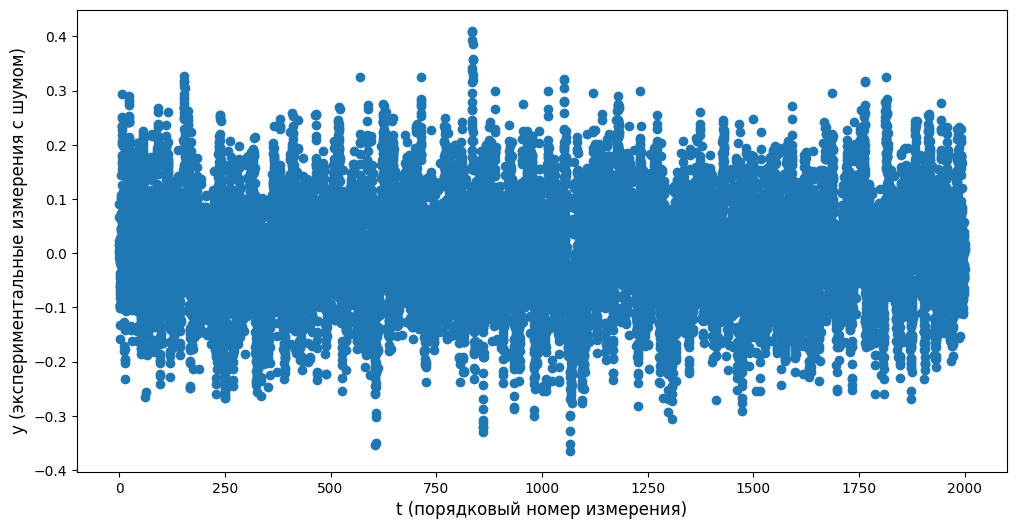

In [ ]:
# изображение исследуемого графика
plt.figure(figsize = (12,6))
plt.plot(t, y, 'o')
plt.xlabel('t (порядковый номер измерения)', fontsize=12)
plt.ylabel('y (экспериментальные измерения с шумом)', fontsize=12)
plt.show()

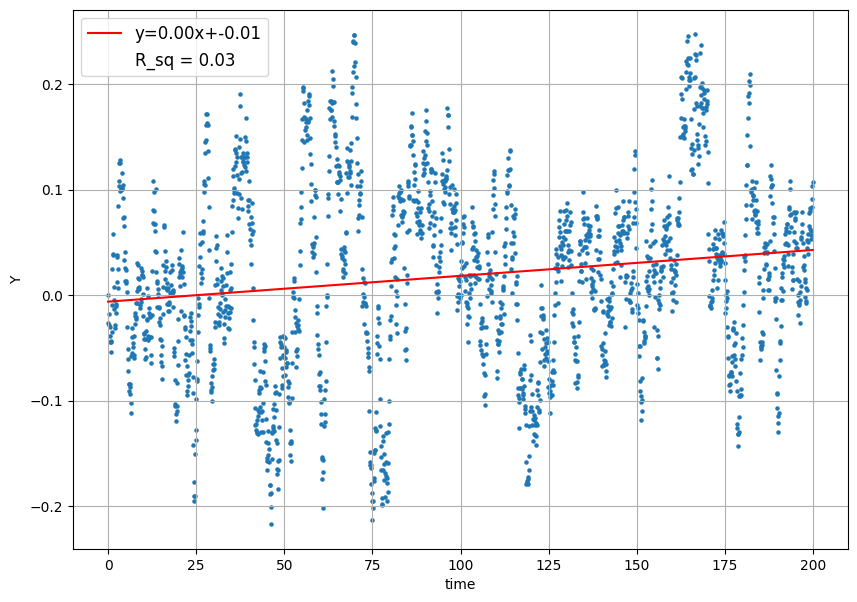

In [ ]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(t,y)
line = slope*t + intercept

fig = plt.figure(figsize=(10,7))
ax = plt.subplot(111)

plt.scatter(t,y, s=5)
plt.plot(t, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
plt.plot([], [], ' ', label='R_sq = '+'{:.2f}'.format(r_value**2))

plt.grid(True)
plt.legend(fontsize=12)
#plt.colorbar()
plt.xlabel('time')
plt.ylabel('Y')
plt.show()

In [ ]:
y_nontrend = y-line

dy_nontrend_dt = np.array([0])
dy_nontrend_dt[0] = 0
for i in range(len(y)-1):
  dy_nontrend_dt = np.append(dy_nontrend_dt, (y_nontrend[i+1] - y_nontrend[i])/(t[i+1] - t[i]))

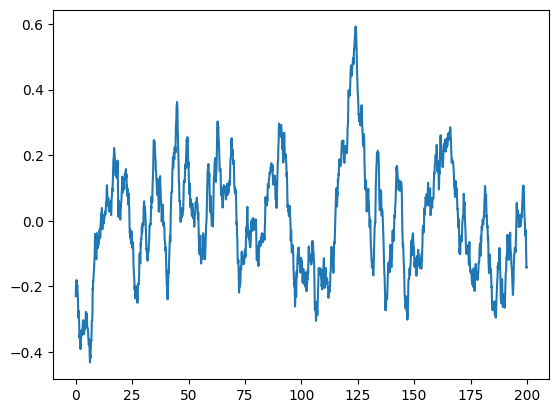

In [ ]:
#plt.plot(t, dy_nontrend_dt)
plt.plot(t, y_nontrend)

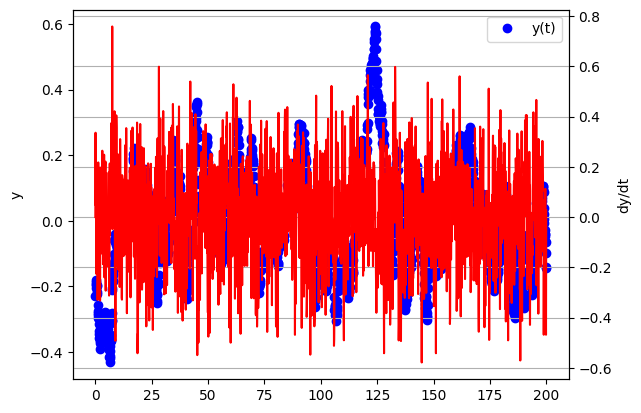

In [ ]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.plot(t,y_nontrend,'o',color='b', label= 'y(t)')
ax1.plot(t,dy_nontrend_dt,color='r', label= 'dy/dt')
ax.set_ylabel('y')
ax1.set_ylabel('dy/dt')
ax.legend()
#ax1.legend()
plt.grid()


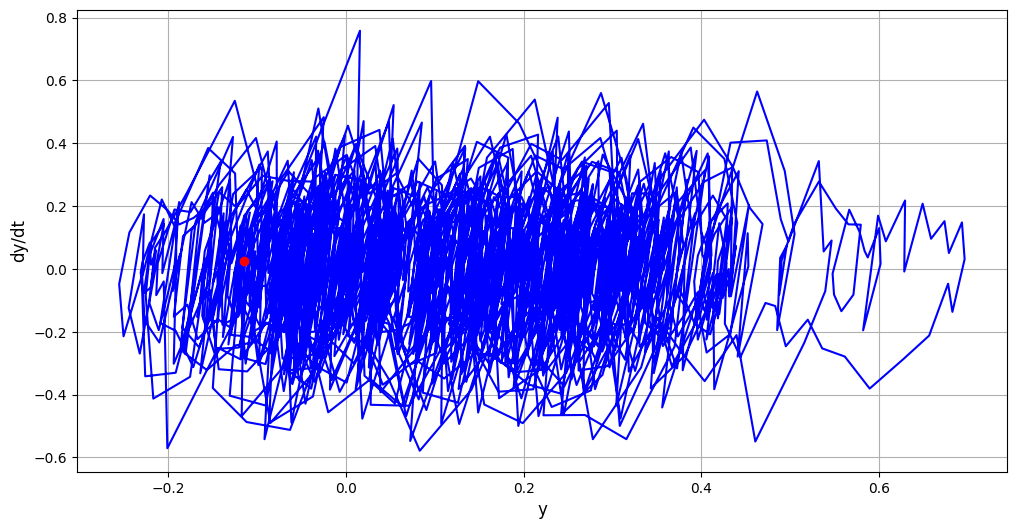

In [ ]:
# изображение исследуемого графика
plt.figure(figsize = (12,6))
plt.plot(y, dy_nontrend_dt,'-b')
plt.plot(y[-1], dy_nontrend_dt[-1],'or')
plt.xlabel('y', fontsize=12)
plt.ylabel('dy/dt', fontsize=12)
plt.grid()
plt.show()

In [ ]:
print("математическое ожидание = ", np.mean(y))
print("среднеквадратическое отклонение = " + "{:.3f}".format(np.std(y)))

математическое ожидание =  0.12813071100719406
среднеквадратическое отклонение = 0.179


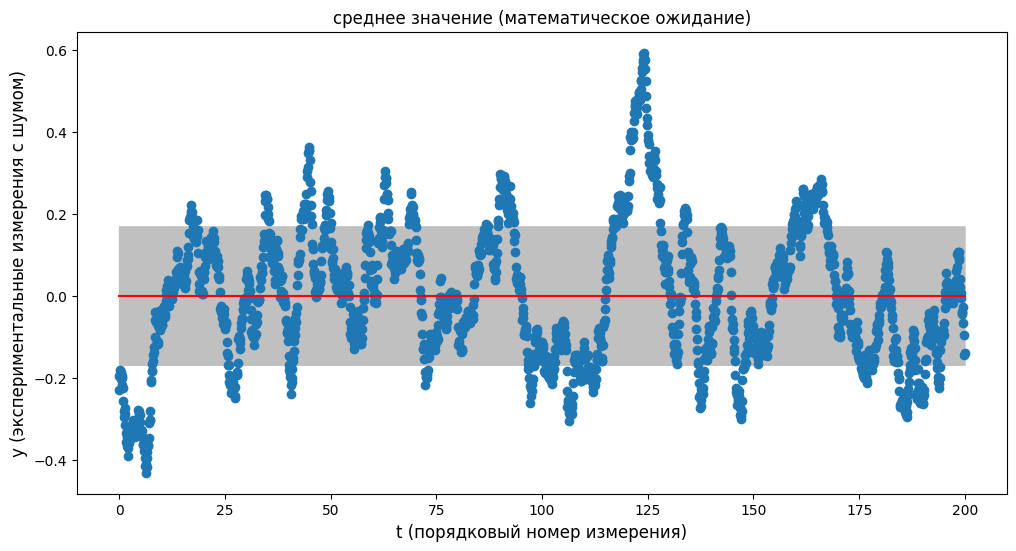

In [ ]:
y = y_nontrend
plt.figure(figsize = (12,6))
plt.plot(t, y, 'o')
plt.plot([t[0], t[-1]],[np.mean(y), np.mean(y)],color='red')
plt.xlabel('t (порядковый номер измерения)', fontsize=12)
plt.ylabel('y (экспериментальные измерения с шумом)', fontsize=12)
plt.title("среднее значение (математическое ожидание)")
plt.fill_between(t, np.mean(y) + np.std(y), np.mean(y) - np.std(y), color = "silver")
plt.show()

In [ ]:
def autocorr(signal, time_period):
  y_acorr = len(time_period) * [0]
  mean = sum(signal)/len(time_period)
  var = sum([(y - mean)**2 for y in signal]) / len(time_period)
  y_norm = [y - mean for y in signal]
  idx = range(len(time_period))
  for l in idx:
      c = 1
      if (l>0):
        tmp = [y_norm[l:][i] * y_norm[:-l][i] for i in range(len(signal) - l)]
        c = sum(tmp) / len(signal) / var
      y_acorr[l] = c
  return y_acorr

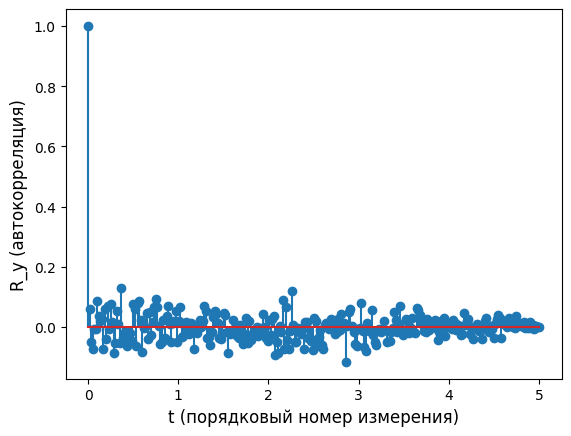

In [ ]:
y_acorr = autocorr(y,t)
plt.stem(t,y_acorr)
plt.xlabel('t (порядковый номер измерения)', fontsize=12)
plt.ylabel('R_y (автокорреляция)', fontsize=12)
plt.show()

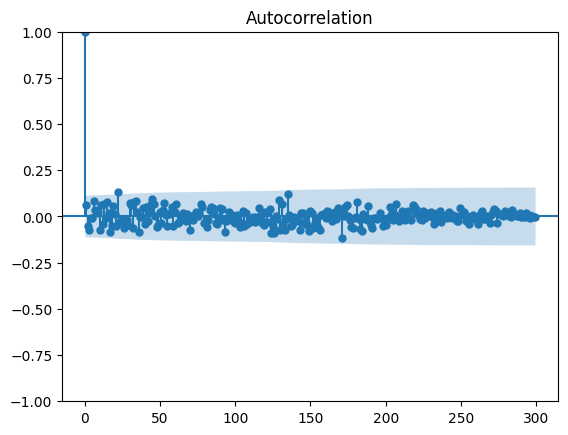

In [ ]:
# автокорреляция
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(y, lags = len(y)-1, fft = True)
plt.show()

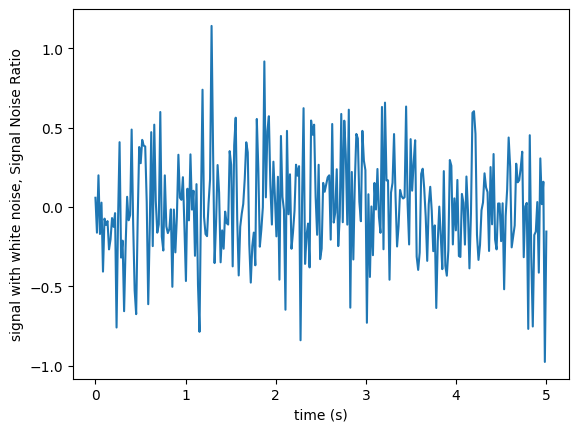

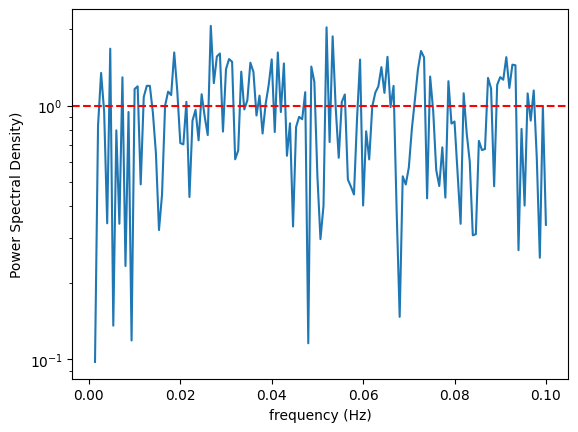

In [ ]:
# спектральная плотность сигнала

f, psd = signal.periodogram(y, 1/T)

#plt.plot(t, signal_with_noise)
#plt.plot(t, signal_pure)
plt.plot(t,y)
plt.xlabel("time (s)")
plt.ylabel('signal with white noise, Signal Noise Ratio')
plt.show()

plt.semilogy(f[2:], np.sqrt(psd[2:]))
plt.xlabel("frequency (Hz)")
plt.ylabel("Power Spectral Density)")
plt.axhline(1, ls="dashed", color="r")
plt.show()

# обработка датафреймов

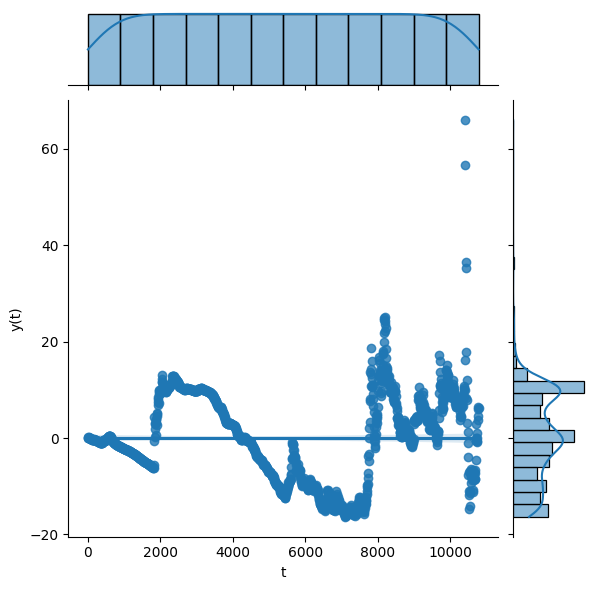

In [ ]:
# создаем датафрейм для красивого изображения данных
# сигнал случайный, формируем одну выборку

d = {'y(t)': y, 't': t}
df = pd.DataFrame(d)
seaborn.jointplot(data=df, x = "t", y = "y(t)",kind='reg')

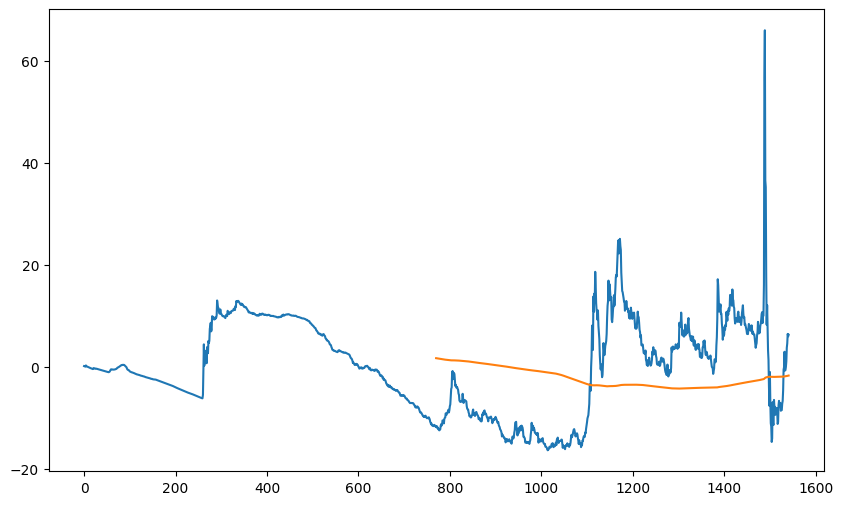

In [ ]:
# расчет скользящего среднего
df['y(t)'].plot(figsize=(10,6))
df['y(t)'].rolling(window = int(len(t)*0.5)).mean().plot()
y_mean = df['y(t)'].rolling(window = int(len(t)*0.5)).mean()

<ipython-input-19-0f5683c2a30d>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = np.sin(t[i]) + noise[i]


Text(0, 0.5, 'y (экспериментальные измерения)')

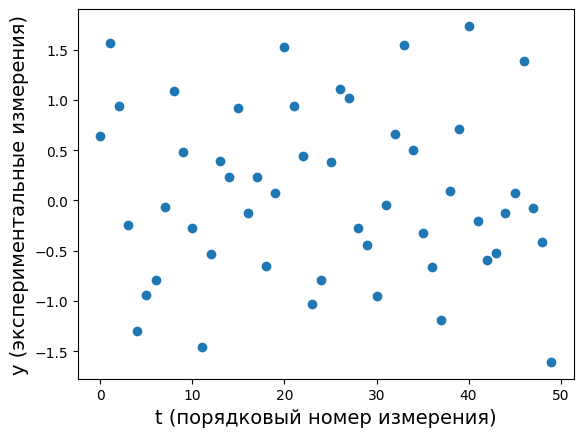

In [ ]:
def dataset_stohastic(mu, noise_sigma, data_size, random_state):
    t = np.arange(0, data_size, 1.)
    random.seed(random_state)
    noise = np.empty((data_size, 1))
    y = np.empty((data_size))

    for i in range(data_size):
        noise[i] = random.gauss(mu, noise_sigma)
        y[i] = np.sin(t[i]) + noise[i]

    return t, y

data_size = 50 # размер генерируемого набора данных
noise_sigma = 0.5 # СКО шума в данных
mu = 0 # математическое ожидание
t, y = dataset_stohastic(mu, noise_sigma, data_size, 1)

plt.plot(t, y, 'o')
plt.xlabel('t (порядковый номер измерения)', fontsize=14)
plt.ylabel('y (экспериментальные измерения)', fontsize=14)

<ipython-input-52-d972b211ec20>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = np.sin(t[i]) + noise[i]


         t         y
0      0.0  0.470858
1      1.0  0.143182
2      2.0  0.569440
3      3.0  0.326372
4      4.0 -1.264977
...    ...       ...
1495  45.0  1.063230
1496  46.0  0.273412
1497  47.0  0.494722
1498  48.0 -1.912562
1499  49.0 -0.709930

[1500 rows x 2 columns]


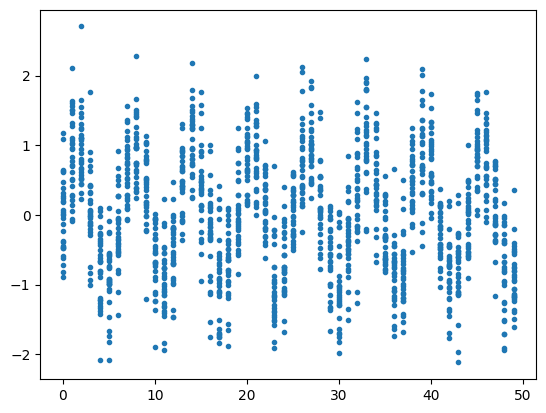

In [ ]:
x_cortege = []
y_cortege = []
for i in range(30):
     x_t, y_t = dataset_stohastic(mu, noise_sigma, data_size, i)
     x_cortege = np.append(x_cortege, x_t)
     y_cortege = np.append(y_cortege, y_t)
plt.plot(x_cortege,y_cortege,'.')
dataframe_cortege = {
    "t": x_cortege,
    "y": y_cortege
}
df = pd.DataFrame(dataframe_cortege)

print(df)

<Axes: xlabel='t', ylabel='y'>

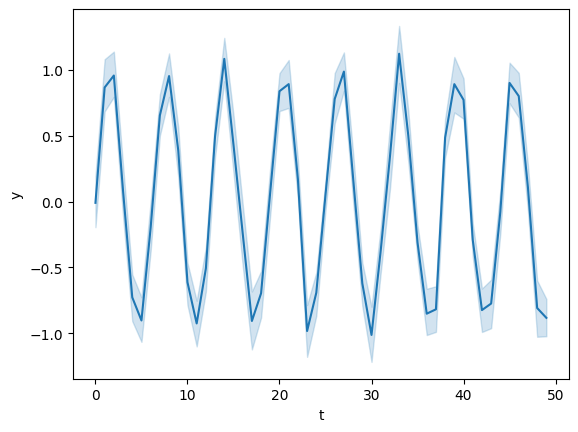

In [ ]:
seaborn.lineplot(x = "t", y= "y", data = df, markers = True)

In [ ]:
df['y'].plot(figsize=(10,6))
df['y'].rolling(window = 20).mean().plot()
y_mean = df['y'].rolling(window = 20).mean()

KeyError: 'y'

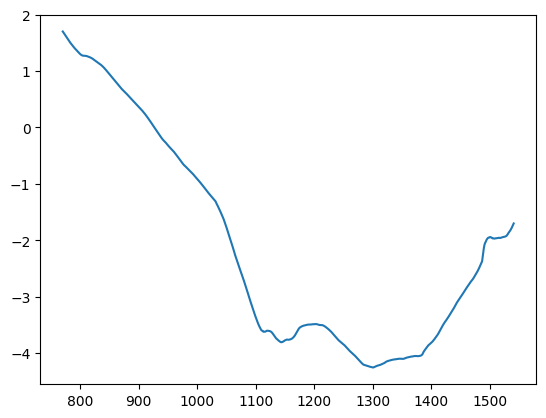

In [ ]:
plt.plot(y_mean)

# экспонента Хёрста и метод DFA

In [ ]:
pip install hurst

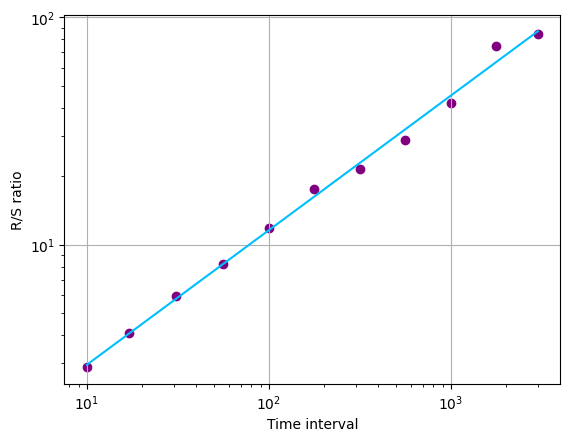

H=0.5924, c=0.7556


In [ ]:
from hurst import compute_Hc
# Evaluate Hurst equation
H, c, data = compute_Hc(y, kind='change', simplified=False)

# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

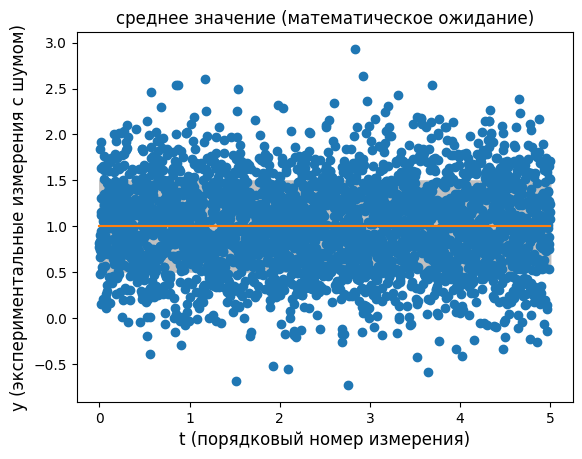

In [ ]:
plt.plot(t, y, 'o')
plt.plot([t[0], t[-1]],[np.mean(y), np.mean(y)])
plt.xlabel('t (порядковый номер измерения)', fontsize=12)
plt.ylabel('y (экспериментальные измерения с шумом)', fontsize=12)
plt.title("среднее значение (математическое ожидание)")
plt.fill_between(t, np.mean(y) + np.std(y), np.mean(y) - np.std(y), color = "silver")
plt.show()

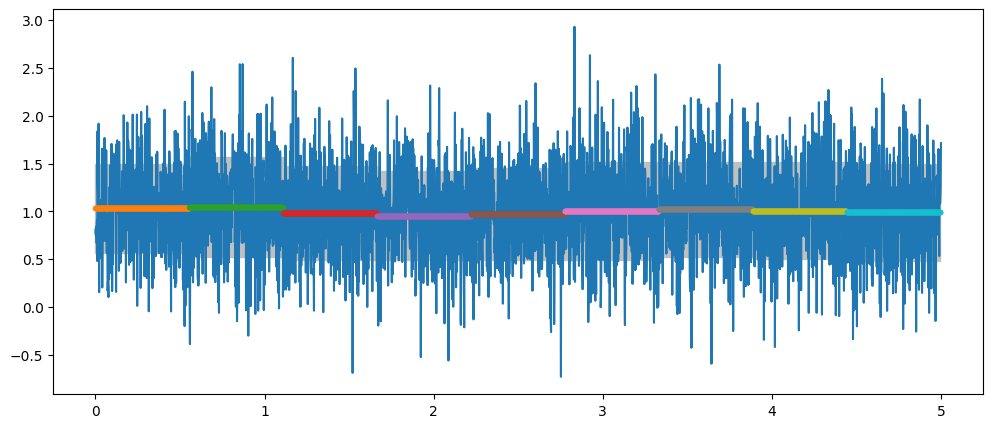

In [ ]:
window_count = 9

len_int = int(len(y)/window_count)

plt.figure(figsize = (12,5))
plt.plot(t,y)
for i in range(0,window_count):
  window_idx = range(0+i*len_int,(1+i)*len_int)
  y_window = np.mean(y[window_idx]) * np.ones(len_int)
  plt.plot(t[window_idx], y_window,".")
  plt.fill_between(t[window_idx], np.mean(y_window) + np.std(y[window_idx]), np.mean(y_window) - np.std(y[window_idx]), color = "silver")



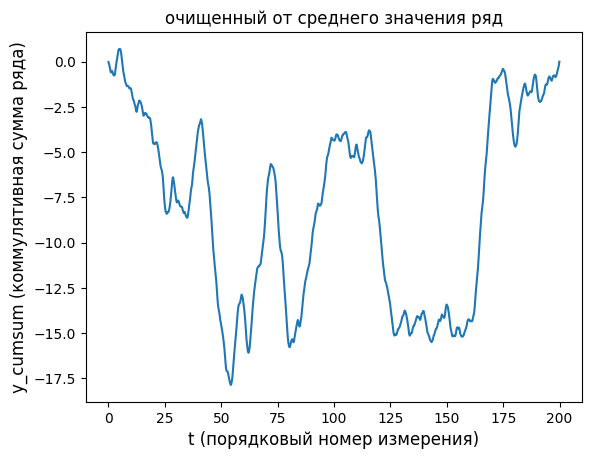

In [ ]:
# сумма накопительным итогом (коммулятивная сумма осредненного ряда)
y_cumsum = []
y_cumsum = np.array([y[0] - np.mean(y)])
for i in range(1,len(y)):
  y_cumsum = np.append(y_cumsum, y_cumsum[i-1] + y[i] - np.mean(y))

plt.plot(t, y_cumsum)
plt.xlabel('t (порядковый номер измерения)', fontsize=12)
plt.ylabel('y_cumsum (коммулятивная сумма ряда)', fontsize=12)
plt.title('очищенный от среднего значения ряд')
plt.show()

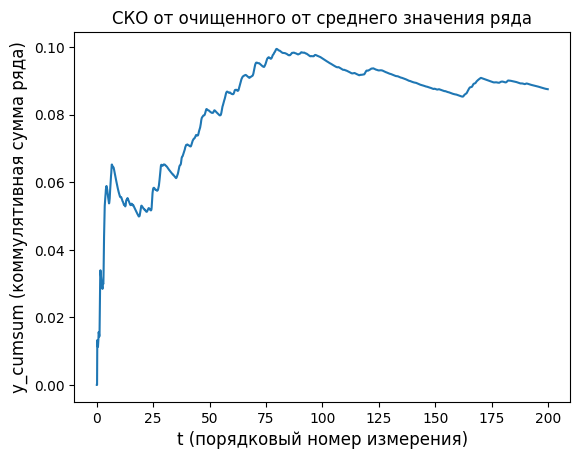

In [ ]:
# СКО в зависимости от значения порядкового номера измерения
y_std = []
y_std = np.array([np.std(y[0]-np.mean(y))])
for i in range(1,len(y)):
  y_std = np.append(y_std, np.std(y[range(0,i)]-np.mean(y)))


plt.plot(t, y_std)
plt.xlabel('t (порядковый номер измерения)', fontsize=12)
plt.ylabel('y_cumsum (коммулятивная сумма ряда)', fontsize=12)
plt.title('СКО от очищенного от среднего значения ряда')
plt.show()

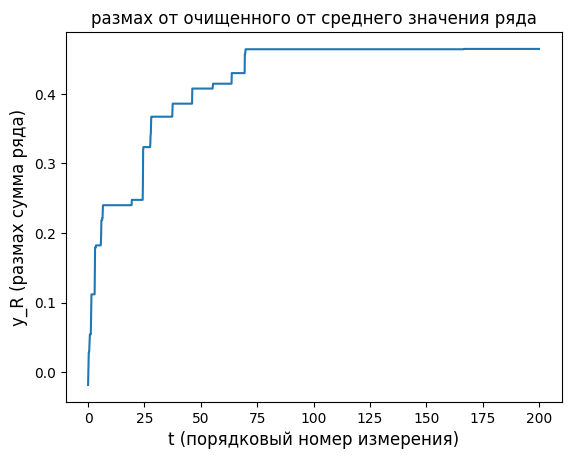

In [ ]:
# Размаз в зависимости от значения порядкового номера измерения
y_R = []
y_R = np.array([(y[0]-np.mean(y))])
for i in range(1,len(y)):
  y_R= np.append(y_R, np.max(y[range(0,i)]) - np.min(y[range(0,i)]))


plt.plot(t, y_R)
plt.xlabel('t (порядковый номер измерения)', fontsize=12)
plt.ylabel('y_R (размах сумма ряда)', fontsize=12)
plt.title('размах от очищенного от среднего значения ряда')
plt.show()

<ipython-input-56-aef09d179bea>:1: RuntimeWarning: divide by zero encountered in divide
  RSstat = y_R / y_std
<ipython-input-56-aef09d179bea>:1: RuntimeWarning: invalid value encountered in divide
  RSstat = y_R / y_std


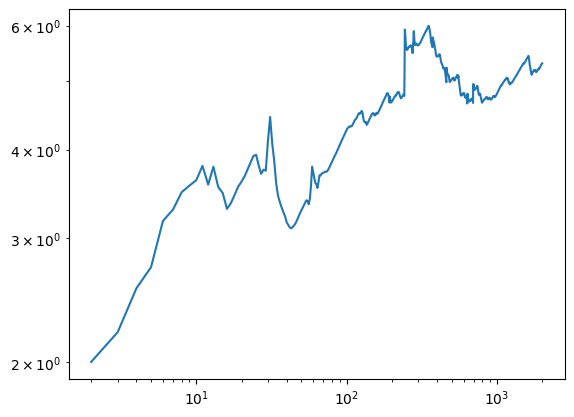

In [ ]:
RSstat = y_R / y_std
plt.loglog(RSstat)

https://mfdfa.readthedocs.io

https://github.com/LRydin/MFDFA/blob/master/MFDFA/MFDFA.py


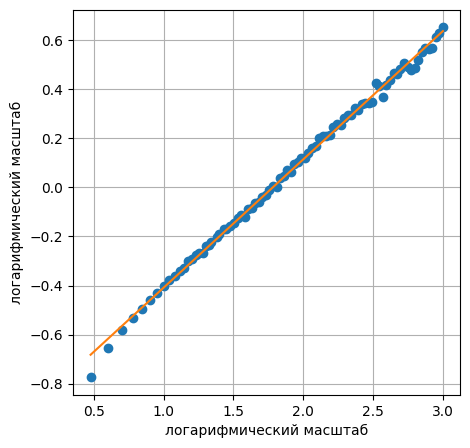

Estimated H = 0.523


In [ ]:
# Imports
from MFDFA import MFDFA

# Select a band of lags, which usually ranges from
# very small segments of data, to very long ones, as
lag = np.unique(np.logspace(0.5, 3, 100, dtype=int))

# Notice these must be ints, since these will segment
# the data into chucks of lag size

# Select the power q
#lets consider only the monofractal case, so we need only 𝑞=2.
q = 2

# The order of the polynomial fitting
order = 1

# Obtain the (MF)DFA as
lag, dfa = MFDFA(y, lag = lag, q = q, order = order)

# To uncover the Hurst index, lets get some log-log plots

# And now we need to fit the line to find the slope
# in a double logaritmic scales, i.e., you need to
# fit the logs of the results

del_nan = np.argwhere(np.isnan(dfa))
dfa = np.delete(dfa,del_nan[:,0])
lag = np.delete(lag,del_nan[:,0])
H_hat, C_hat = np.polyfit(np.log10(lag)[0:-1],np.log10(dfa[0:-1]),1)

plt.figure(figsize=(5, 5))
plt.plot(np.log10(lag),np.log10(dfa),"o")
tlin = np.linspace(np.log10(lag[0]),np.log10(lag[-1]), num=100)
plt.plot(tlin, H_hat*tlin + C_hat)
plt.xlabel("логарифмический масштаб")
plt.ylabel("логарифмический масштаб")
plt.grid()
plt.show()

print('Estimated H = '+'{:.3f}'.format(H_hat))

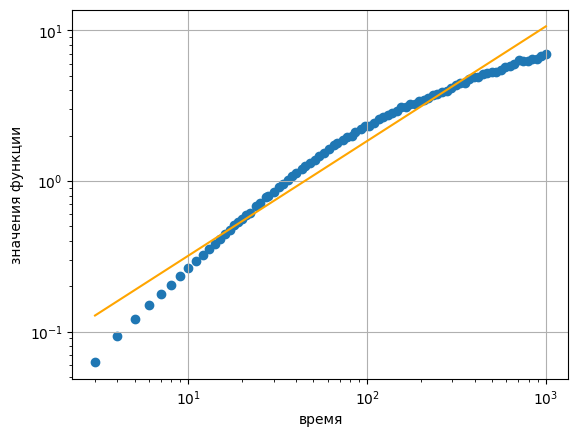

In [ ]:
plt.loglog(10**(tlin), 10**(H_hat*tlin + C_hat), color = "orange")
plt.scatter(lag,dfa)
plt.xlabel("время")
plt.ylabel("значения функции")
plt.grid()
plt.show()

# разобрать




In [ ]:
pip install scipy

In [ ]:
from scipy import stats
def dfa(signal, scales):
    flucts = []
    for s in scales:
        windows = np.array([signal[i:i + s] for i in range(0, len(signal), s) if i + s <= len(signal)])
        detrended_windows = np.array([window - stats.linregress(np.arange(s), window)[0] * np.arange(s) - stats.linregress(np.arange(s), window)[1] for window in windows])
        F = np.sqrt(np.mean(detrended_windows**2, axis=1))
        flucts.append(np.mean(F))
    return np.array(flucts)

def sliding_window_std(signal, window_size):
    std_vals = np.array([np.std(signal[i:i+window_size]) for i in range(len(signal) - window_size + 1)])
    return std_vals

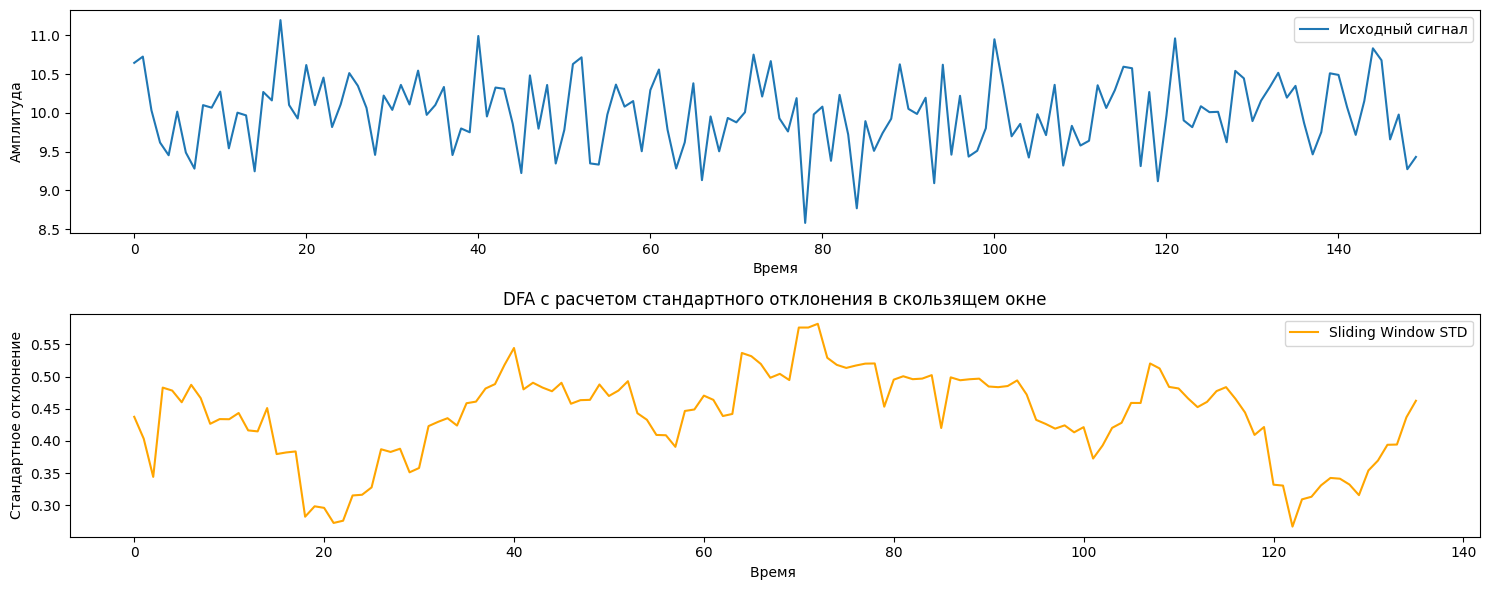

In [ ]:
window_size = int(len(y)/10)

std_vals = sliding_window_std(y, window_size)

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(t, y, label='Исходный сигнал')
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t[:-(window_size-1)], std_vals, label='Sliding Window STD', color='orange')
plt.title('DFA с расчетом стандартного отклонения в скользящем окне')
plt.xlabel('Время ')
plt.ylabel('Стандартное отклонение')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
scales = np.arange(int(t[1]), int(t[-1]), 1)
flucts = dfa(y, scales)
log_scales = np.log10(scales)
log_flucts = np.log10(flucts)
hurst_exponent, _, _, _, _ = stats.linregress(log_scales, log_flucts)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


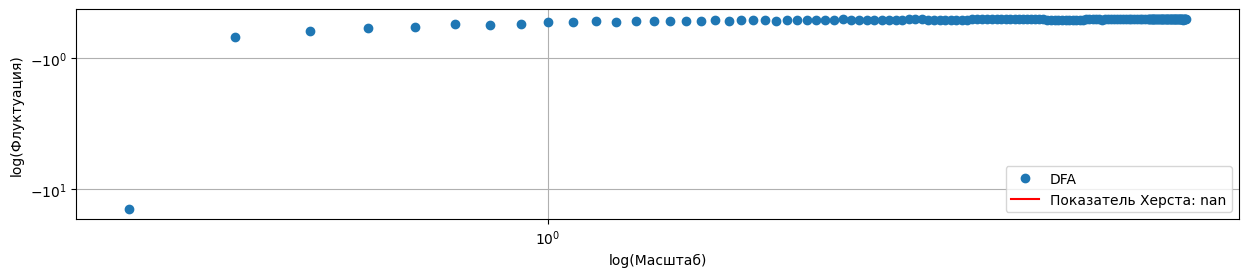

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(log_scales, log_flucts, 'o', label='DFA')
plt.plot(log_scales, hurst_exponent*log_scales + _, 'r', label=f'Показатель Херста: {hurst_exponent:.2f}')
plt.xscale("symlog")
plt.yscale("symlog")
plt.xlabel('log(Масштаб)')
plt.ylabel('log(Флуктуация)')
plt.grid()
plt.legend()

# **Пример обработки файла с историческими данными о курсе доллара к рублю**

In [ ]:
# загрузить последовательность из внешнего файла
# загрузить курс доллара
data_file = pd.read_csv("UsdRubTime.csv", sep = ';')

x_axis = 'Week'
y_axis = 'Close'

df_data = pd.DataFrame(data_file, columns = [x_axis, y_axis])

y = df_data[y_axis]
T = max(df_data[x_axis])
N = len(df_data[x_axis])
t = np.linspace(1, T, N)

In [ ]:
# обработка данных
print(df_data.head)

print(N, T)

In [ ]:
# загрузить последовательность из внешнего файла
# загрузить курс доллара
data_file = pd.read_csv("VVP Russia.csv", sep = ';')

x_axis = 'Year'
y_axis = 'GDPusd'

df_data = pd.DataFrame(data_file, columns = [x_axis, y_axis])

y = df_data[y_axis]
T = max(df_data[x_axis])
N = len(df_data[x_axis])
t = np.linspace(1, T, N)

In [ ]:
# удалить все данные из файла, которые больше чем заданный параметр
df_data = df_data[df_data.Week > 350]

print(df_data.head)

AttributeError: ignored

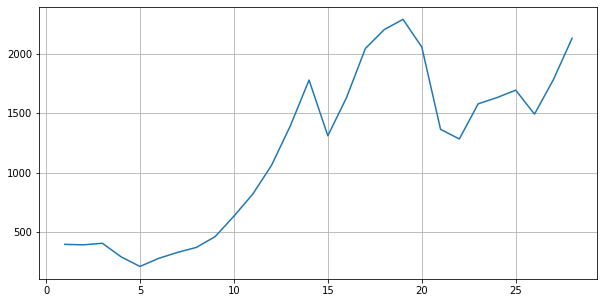

In [ ]:
# график временной зависимости
plt.figure(figsize = (10,5))
plt.grid()
plt.plot(t, y)
plt.show()

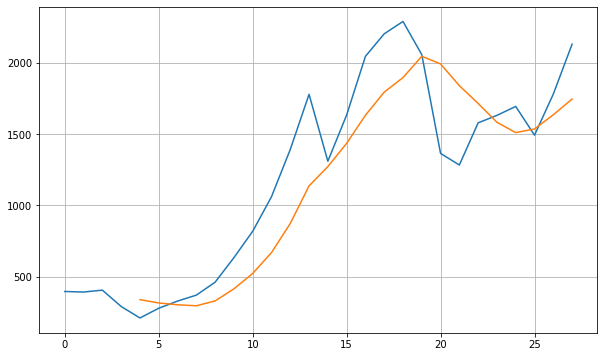

In [ ]:
# расчет скользящего среднего
y.plot(figsize=(10,6))
y.rolling(window = 5).mean().plot()
y_mean = y.rolling(window = 35).mean()
plt.grid()
plt.show()

In [ ]:
y_mean = y_mean[~np.isnan(y_mean)]
print(y_mean.head)

<bound method NDFrame.head of 4      338.438
5      314.944
6      302.254
7      295.248
8      329.350
9      413.948
10     521.884
11     668.228
12     872.584
13    1136.114
14    1271.396
15    1434.414
16    1631.338
17    1793.536
18    1895.706
19    2045.188
20    1991.360
21    1838.970
22    1714.118
23    1582.402
24    1509.750
25    1535.356
26    1634.824
27    1745.142
Name: GDPusd, dtype: float64>


<function matplotlib.pyplot.show(close=None, block=None)>

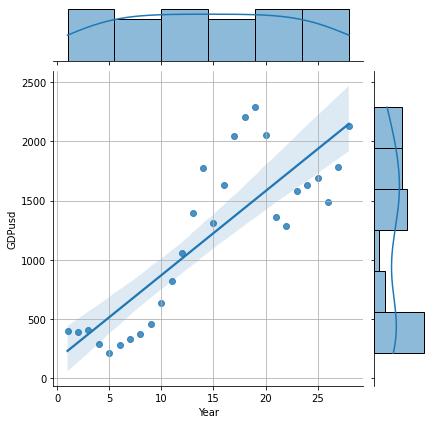

In [ ]:
seaborn.jointplot(data = df_data, x = x_axis, y = y_axis, kind='reg')
plt.grid()
plt.show

In [ ]:
from scipy.fft import fft, fftfreq

yf = fft(y.values)
xf = fftfreq(N, T/N)[:N//2]
# спект Фурье симметричен относительно нуля, поэтому берем только правую его часть
plt.figure(figsize=(10, 5))
plt.plot(xf, np.abs(yf[0:N//2]),label='FFT преобразование')
plt.xlabel('Частота[Герц]', fontsize=12)
plt.ylabel('спектр Фурье', fontsize=12)
plt.xticks(np.arange(0, np.max(xf), 0.1))
#plt.ylim(0,2000)
plt.grid()
plt.legend()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'values'

https://www.dmitrymakarov.ru/intro/time-series-20/#2-analiz-vremennykh-ryadov

In [ ]:
# автокорреляция
import statsmodels.api as sm

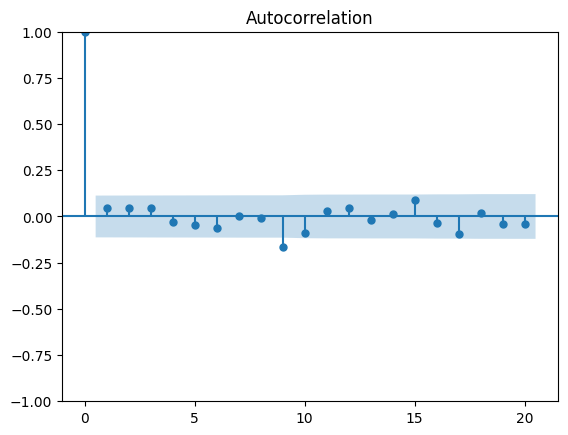

In [ ]:
sm.graphics.tsa.plot_acf(y, lags = 20, fft = True)
plt.show()

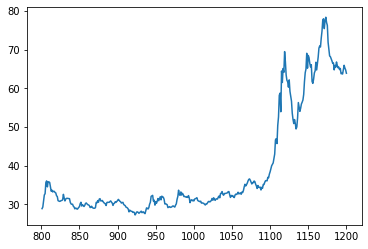

In [ ]:
plt.plot(t[800:1200], y[800:1200])


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:472: RuntimeWarning: Mean of empty slice.
  xo = x - x.mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: negative dimensions are not allowed

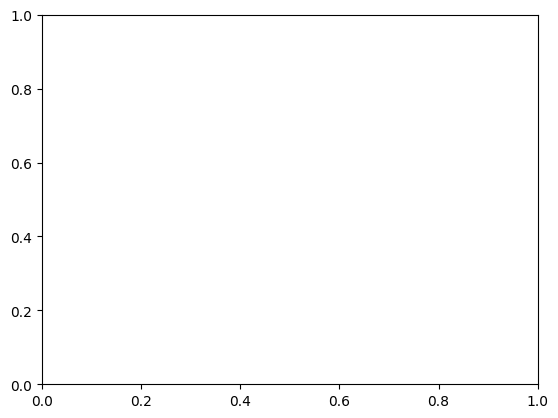

In [ ]:
sm.graphics.tsa.plot_acf(y[800:1200], lags = 250)


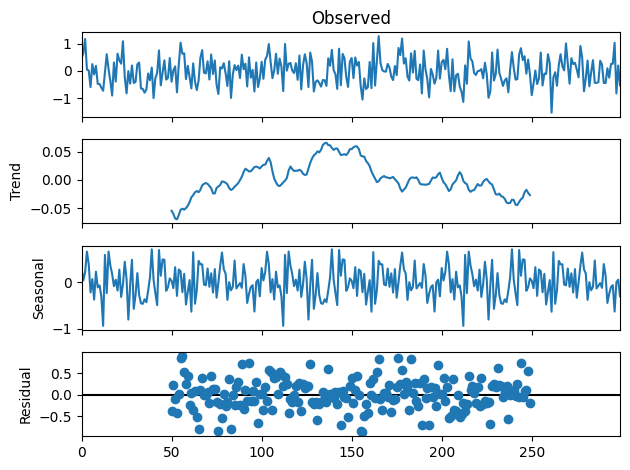

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(y, period = 100, model = "additive")
decompose.plot()


plt.show()

# Гипотеза Дикки-Фуллера

In [ ]:
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fuller Test:')
dftest = adfuller(y, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

print('P-value', dfoutput[1])
print('The p-value is less than .05? we reject the null hypothesis. H0: The time series is non-stationary. ')

Results of Dickey-Fuller Test:
Test Statistic                -1.359791e+01
p-value                        1.978727e-25
#Lags Used                     1.000000e+00
Number of Observations Used    2.980000e+02
Critical Value (1%)           -3.452486e+00
Critical Value (5%)           -2.871288e+00
Critical Value (10%)          -2.571964e+00
dtype: float64
P-value 1.978726795385293e-25
The p-value is less than .05? we reject the null hypothesis. H0: The time series is non-stationary. 


#Higuchi's Fractal Dimension (HFD)

The range of values for HFD lie between 1 and 2—1 for a simple curve and 2 for a randomly dis- tributed curve that nearly fills the Euclidean 2D space.

In [ ]:
#!/usr/bin/python3

"""
Higuchi Fractal Dimension according to:
T. Higuchi, Approach to an Irregular Time Series on the
Basis of the Fractal Theory, Physica D, 1988; 31: 277-283.
"""

import os
import ctypes
import numpy as np
from numpy.ctypeslib import ndpointer

def curve_length(X,opt=False,num_k=50,k_max=None):
    """
    Calculate curve length <Lk> for Higuchi Fractal Dimension (HFD)

    Input:

    X - input (time) series (must be 1D, to be converted into a NumPy array)
    opt (=True) - optimized? (if libhfd.so was compiled uses the faster code).
    num_k - number of k values to generate.
    k_max - the maximum k (the k array is generated uniformly in log space
            from 2 to k_max)
    Output:

    k - interval "times", window sizes
    Lk - curve length
    """
    ### Make sure X is a NumPy array with the correct dimension
    X = np.array(X)
    if X.ndim != 1:
        raise ValueError("Input array must be 1D (time series).")
    N = X.size

    ### Get interval "time"
    k_arr = interval_t(N,num_val=num_k,kmax=k_max)

    ### The average length
    Lk = np.zeros(k_arr.size)

    ### C library
    if opt:
        X = np.require(X, float, ('C', 'A'))
        k_arr = np.require(k_arr, ctypes.c_size_t, ('C', 'A'))
        Lk = np.require(Lk, float, ('C', 'A'))
        ## Load library here
        libhfd = init_lib()
        ## Run the C code here
        libhfd.curve_length(k_arr,k_arr.size,X,N,Lk)

    else:
        ### Native Python run
        for i in range(k_arr.size):# over array of k's
            Lmk = 0.0
            for j in range(k_arr[i]):# over m's
                ## Construct X_k^m, i.e. X_(k_arr[i])^j, as X[j::k_arr[i]]
                ## Calculate L_m(k)
                Lmk += (
                    np.sum(
                        np.abs(
                            np.diff( X[j::k_arr[i]] )
                        )
                    )
                    * (N - 1) /
                    (
                        ( (N-j-1)//k_arr[i] )
                        *
                        k_arr[i]
                    )
                ) / k_arr[i]

            ### Calculate the average Lmk
            Lk[i] = Lmk / k_arr[i]

    return (k_arr, Lk);

def lin_fit_hfd(k,L,log=True):
    """
    Calculate Higuchi Fractal Dimension (HFD) by fitting a line to already computed
    interval times k and curve lengths L

    Input:

    k - interval "times", window sizes
    L - curve length
    log (=True) - k and L values will be transformed to np.log2(k) and np.log2(L),
                  respectively

    Output:

    HFD
    """
    if log:
        return (-np.polyfit(np.log2(k),np.log2(L),deg=1)[0]);
    else:
        return (-np.polyfit(k,L,deg=1)[0]);

def hfd(X,**kwargs):
    """
    Calculate Higuchi Fractal Dimension (HFD) for 1D data/series

    Input:

    X - input (time) series (must be 1D, to be converted into a NumPy array)

    Output:

    HFD
    """
    k, L = curve_length(X,**kwargs)
    return lin_fit_hfd(k, L);

def interval_t(size,num_val=50,kmax=None):
    ### Generate sequence of interval times, k
    if kmax is None:
        k_stop = size//2
    else:
        k_stop = kmax
    if k_stop > size//2:## prohibit going larger than N/2
        k_stop = size//2
        print("Warning: k cannot be longer than N/2")

    k = np.logspace(start=np.log2(2),stop=np.log2(k_stop),base=2,num=num_val,dtype=int)
    return np.unique(k);

def init_lib():
    libdir = os.path.dirname(__file__)
    libfile = os.path.join(libdir, "libhfd.so")
    lib = ctypes.CDLL(libfile)

    rwptr = ndpointer(float, flags=('C','A','W'))
    rwptr_sizet = ndpointer(ctypes.c_size_t, flags=('C','A','W'))

    lib.curve_length.restype = ctypes.c_int
    lib.curve_length.argtypes = [rwptr_sizet, ctypes.c_size_t, rwptr, ctypes.c_size_t, rwptr]

    return lib;

In [ ]:
z = np.linspace(0,1,1000)

In [ ]:
import numpy as np
#import HiguchiFractalDimension as hfd

x = np.random.randn(10000)
y = np.empty(9900)
z = np.linspace(0,1,1000)
for i in range(x.size-100):
	y[i] = np.sum(x[:(i+100)])

## Note x is a Guassian noise, y is the original Brownian data used in Higuchi, Physica D, 1988.
## z - is a just linearity)

hfd(x) # ~ 2.00
hfd(y) # ~ 1.50
hfd(z) # = 1
hfd(y_nontrend)
print(hfd(x), hfd(y), hfd(z), hfd(y_nontrend))

1.999874566815698 1.4905649864640167 1.0000000000000004 1.9931507235057702


# Maximum Lyapunov Exponent (MLE)

https://github.com/sreguyal/lyapunov-exponent-estimate/blob/main/LyapunovEstimateTest.ipynb

\begin{equation}
 |\delta \mathbf{Z}(t)| \approx e^{\lambda t}\left|\delta \mathbf{Z}_{0}\right|
\end{equation}

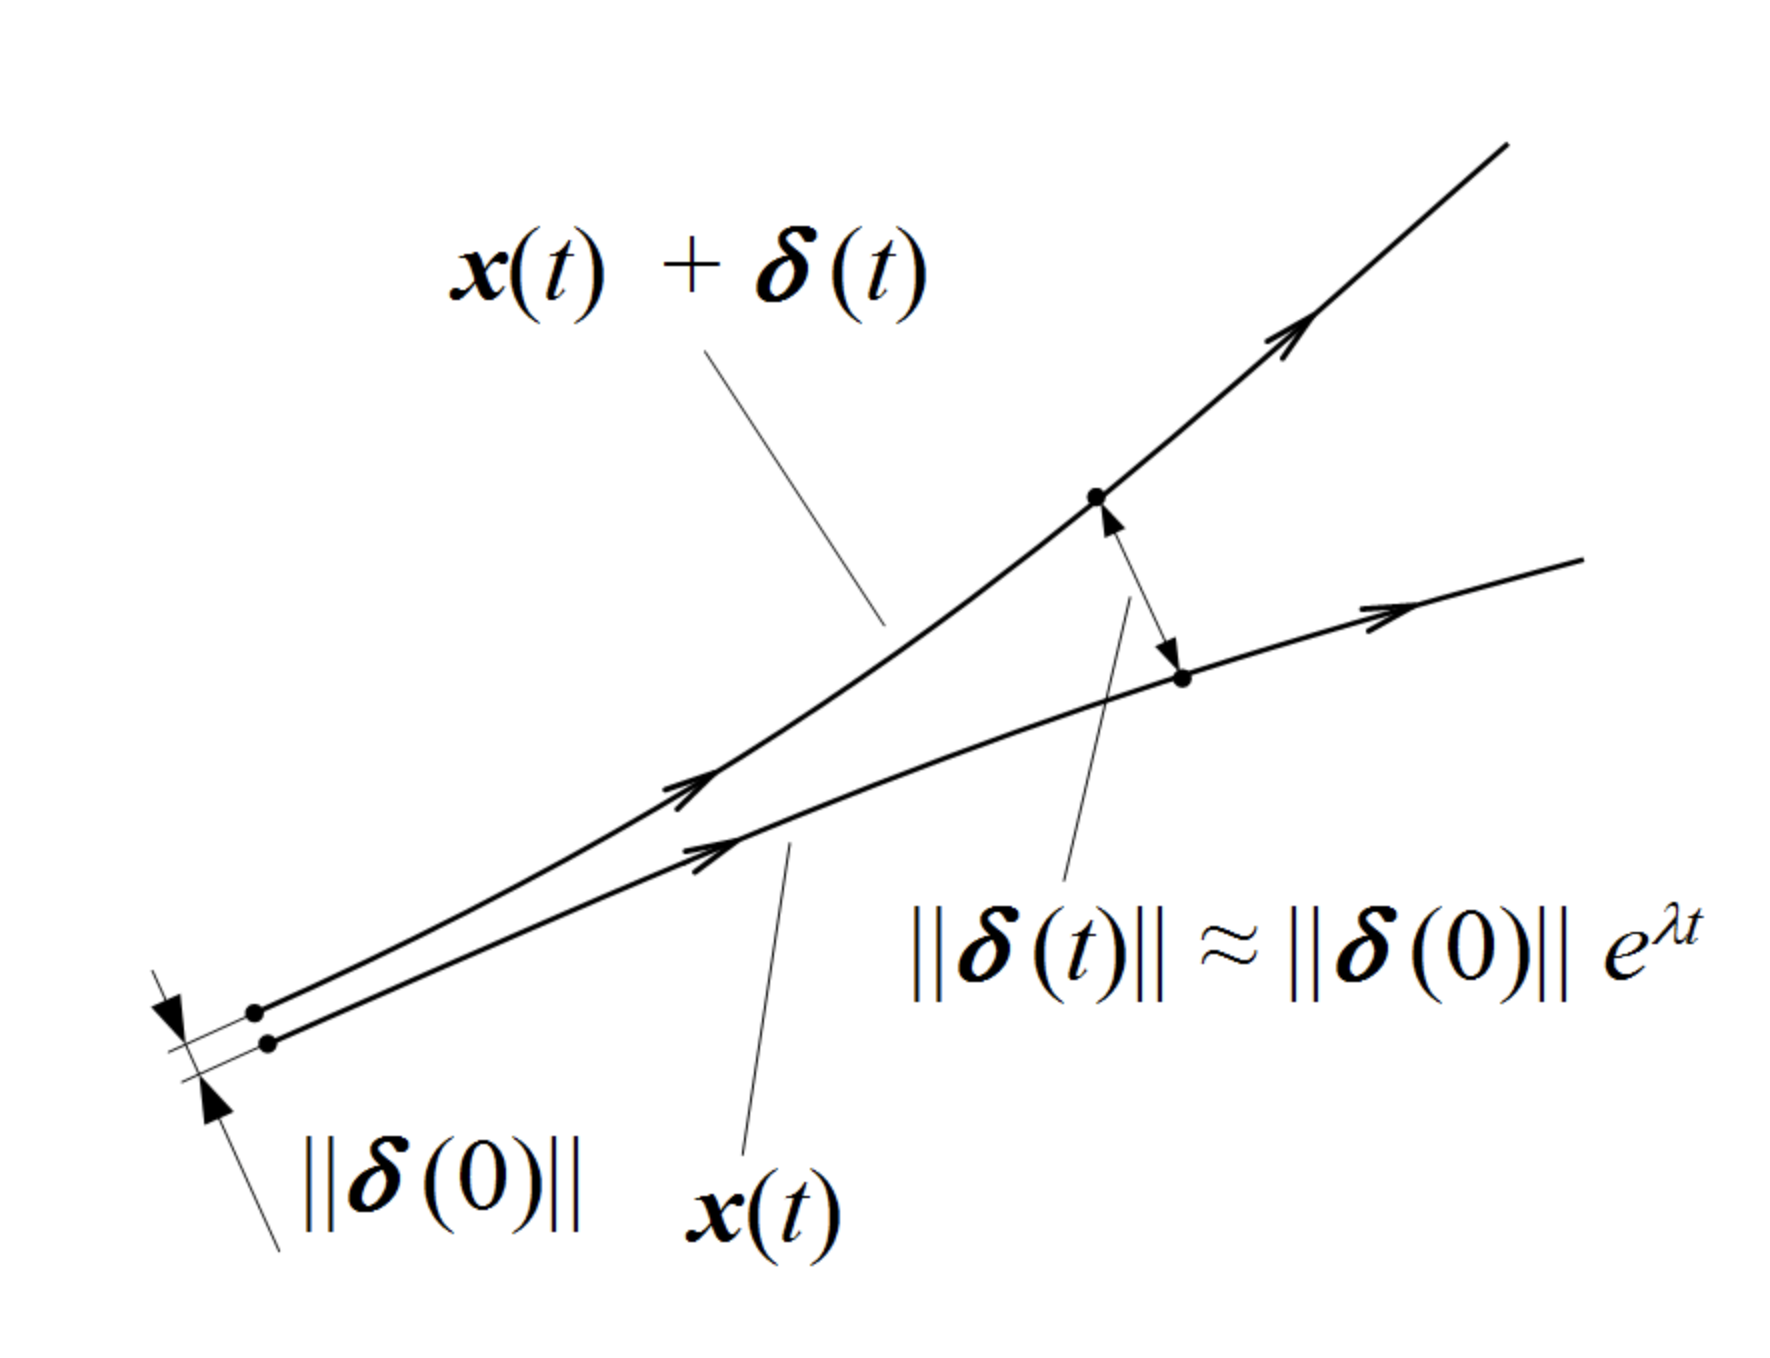

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft, signal, integrate

from mpl_toolkits import mplot3d
from tqdm import tqdm

#contains a variety of methods for analyzing chaotic behavior
#solve for Lyapunov exponent for experimental data
#find dominant periods in data based on FFT
#solve Lorenz and Roessler attractors

def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    cos_this_angle = np.clip(np.dot(unit_vector(v1), unit_vector(v2)), -1, 1)
    return np.arccos(cos_this_angle)

def find_periods(x, step_size, plot=False, max_periods=10):
    return my_periods

def lyapunov_solve(x, step_sz, period, evolv_t_orbits=1, scalmx=0.5, scalmn=0.05,
                   anglmx=0.2, print_debug=0, plot_replace=0, plot_convergence=0):
    '''
    Estimate the largest Lyapunov exponent of input experimental data of dimension
    at least 3. If the data settles on a stable attracting point, break calc and
    return -100. If the data is periodic for a long time, break calc and return 0.

    Args: x = the experimental data / trajectory, dim >=3
          step_sz = time btwn datapts in trajectory
          period = period or indicative timescale of data
          evolv_t_orbits = # of orbits between vector replacements
          scalmx = max length of vector replacement
          scalmn = min length of vector replacement
          anglmx = max angle of vector replacement
          print_debug = print vals for debugging
          plot_replace = plot the vector replacement process for data dim=3
          plot_convergence = plot convergence of lambda_1 with time for data dim=3
    '''

    #system, calc. params
    npt = x.shape[0] # num samples
    orbit = int(period/step_sz) # samples within an orbit
    fid_pt = x[0] # I.C. of orbit
    evolv_t_steps = int(evolv_t_orbits*orbit) #steps btwn replacements

    if print_debug:
       print("npt ", npt, " orbit ", orbit, " evolv_t_steps ", evolv_t_steps)

    #first, find the closest pt.
    closest_pt_ind = orbit
    closest_pt_dist = np.linalg.norm(fid_pt - x[orbit])

    for i in range(orbit+1, npt-evolv_t_steps-1):
        this_dist = np.linalg.norm(fid_pt - x[i])
        if scalmn < this_dist < closest_pt_dist:
            closest_pt_dist = this_dist
            closest_pt_ind = i

    if closest_pt_dist < scalmn:
        return -100 #the datapts are too close, stable attracting point

    #calculation, plotting params
    closest_pt = x[orbit]
    lambda_1 = 0
    i_max = npt-evolv_t_steps
    no_div_steps = 0
    if plot_replace:
        fid_pt_plt = []
        old_l_plt = []
        new_l_plt = []
    if plot_convergence:
        lambda_1_evolv = []
        t = []
                    #found a pt, update our closest_pt values, turn off search
                    if this_angle < closest_l_angle:
                        closest_l_angle = this_angle
                        closest_pt = x[j]
                        closest_pt_ind = j
                        search = 0

            #loosen requirenents
            if search:
                if scalmx_mult < 5:
                    scalmx_mult +=1
                elif closest_l_angle == anglmx:
                    closest_l_angle = anglmx*2
                else:
                    break #fail to find a closer point, search=1

        if plot_replace:
            fid_pt_plt.append(fid_pt);
            old_l_plt.append(l_prime_pt)
            new_l_plt.append(closest_pt)

        # if we didn't find a new point, break if the neighbor is at the end
        # of the trajectory. otherwise, leave as is
        if search:
            if closest_pt_ind + evolv_t_steps >= npt:
                print("no close neighbors, broke calc at", i, "/", npt, " timesteps")
                return lambda_1/(i*step_sz)

    if plot_replace:
        fig = plt.figure(figsize=(20, 15))
        ax = plt.axes(projection='3d')
        ax.set_title('Calculation Replacement Process')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        for i in range(len(fid_pt_plt)):
            this_fid_pt = fid_pt_plt[i]
            this_old_l_pt = old_l_plt[i]
            this_new_l_pt = new_l_plt[i]

            old_l_x = np.asarray([this_fid_pt[0], this_old_l_pt[0]])
            old_l_y = np.asarray([this_fid_pt[1], this_old_l_pt[1]])
            old_l_z = np.asarray([this_fid_pt[2], this_old_l_pt[2]])

            new_l_x = np.asarray([this_fid_pt[0], this_new_l_pt[0]])
            new_l_y = np.asarray([this_fid_pt[1], this_new_l_pt[1]])
            new_l_z = np.asarray([this_fid_pt[2], this_new_l_pt[2]])

            ax.plot(old_l_x, old_l_y, old_l_z, color='royalblue')
            ax.plot(new_l_x, new_l_y, new_l_z, color='coral')

        fid_pt_plt = np.asarray(fid_pt_plt)
        ax.scatter(fid_pt_plt[:,0], fid_pt_plt[:,1], fid_pt_plt[:,2], color='red', marker='o')
        plt.show()

    if plot_convergence:
        fig = plt.figure(figsize=(12,8))
        plt.title('Convergence of Lyapunov Exponent Over Time')
        plt.xlabel('Time')
        plt.ylabel('Lyapunov Exponent')
        plt.plot(t, lambda_1_evolv, color='black')

    return lambda_1/(npt*step_sz)


def lyapunov_solve_unknown(x,step_sz, default_pd=10):
    '''
    Estimates the Lyapunov exponent of experimental
    data. Supplies the x_max and period args to the
    lyapunov_solve function
    args: x = experimental data, dim >=3
          step_sz = timestep btwn datapoints
          default_pd = period if FFT can't find a period
    '''

    period_estimate = find_periods(x[:,0], step_sz, max_periods=5)
    if len(period_estimate) > 0:
        poss_periods = [i for i,v in enumerate(period_estimate) if v>0.5]
        if len(poss_periods) > 0:
            period_estimate = period_estimate[poss_periods[0]]
        else:
            period_estimate = default_pd
    else:
        period_estimate= default_pd

    x_max = 0.1*(np.ptp(x,axis=0)[0])

    return lyapunov_solve(x, step_sz, period_estimate, scalmx=x_max)

# =========================================================================
# example attractors
# =========================================================================

a = 0.15
b = 0.20
c = 10.0

def roessler_eqn(x_3, t0):
  x, y, z = x_3
  return [-y-z, x+a*y, b+z*(x-c)]

def solve_roessler(max_time = 500, step_size = 0.01):

  #choose N random starting points, uniformly distributed [-15, 15)
  np.random.seed(1)
  x0 = -15 + 30*np.random.random(3)

  #define timesteps [0, mt). 250 timesteps per unit time
  t = np.linspace(0, max_time, int(max_time/step_size))

  #integrate ODE for each random starting point
  x_t = np.asarray(integrate.odeint(roessler_eqn, x0, t))

  return t, x_t

# key params
sigma = 6.5
beta = 8.0/3
rho = 30.0

def lorenz_eqn(x_3, t0):
  x, y, z = x_3
  return [sigma*(y-x), x*(rho-z) - y, x*y - beta*z]

def solve_lorenz(max_time = 500, step_size = 0.01):

  #choose N random starting points, uniformly distributed [-15, 15)
  np.random.seed(1)
  x0 = -15 + 30*np.random.random(3)

  #define timesteps [0, mt). 250 timesteps per unit time
  t = np.linspace(0, max_time, int(max_time/step_size))

  #integrate ODE for each random starting point
  x_t = np.asarray(integrate.odeint(lorenz_eqn, x0, t))

  return t, x_t

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 84)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from LyapunovExponentEstimate import lyapunov_solve, lyapunov_solve_unknown, solve_roessler, solve_lorenz
%matplotlib inline

ModuleNotFoundError: No module named 'LyapunovExponentEstimate'

In [ ]:
t, x_t = solve_lorenz(max_time=500, step_size=0.01)
plt.plot(t, x_t)

x_t = x_t[2000:] #crop transient
fig = plt.figure(figsize=(15, 12))
ax = plt.axes(projection='3d')
ax.set_title('Numerical Solution to Lorenz Attractor')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.plot(x_t[:,0], x_t[:,1], x_t[:,2])
plt.show()

lorenz_t = x_t